<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>DECam HiTS Analysis Notebook</b> <br>
Contact author: Erin Howard<br>
Last verified to run: March 1, 2023<br>
LSST Science Piplines version: w_2023_04<br>
Container Size: Large <br>

# DM-37696: ApPipeWithFakes on DECam HiTS with Auto Convolution, February 2023

DECam HiTS with convolution mode set to auto, compared with February 2023 base run.

* Uses `decam_rings_v1` skymap
* Templates from HiTS 2014 are in `/sdf/group/rubin/repo/main/u/elhoward/DM-36024/templates`
* Final processing of HiTS 2015 is in `u/elhoward/DM-37696/HiTS-fakes`
* Postgres schema is `elhoward_dm37696_hits_appipewithfakes`
* Working directory on USDF with bps logs, pipelines, etc. is `/project/elhoward/repo-main-logs/DM-37696`

For ApPipeWithFakes.yaml:
```
inCollection: DECam/defaults/hits2015,u/mrawls/DM-34710-hits-crosstalk-sources,u/mrawls/DM-34710/templates
dataQuery: "instrument='DECam' AND skymap='decam_rings_v1' AND detector NOT IN (2, 61) AND exposure>400000"
```

Notes: The exposure cuts are necessary to force each pipeline to use only the 2014 images (numbered in the 200000s) for template building, and to use only the 2015 images (numbered in the 400000s) as science images.

## Previous Runs
-  [DM-35284: ApPipeWithFakes on DECam HiTS, November 2022](./DM-35284-AP-DECam-HiTS-Nov2022.ipynb) (Data has since been corrupted)
-  [DM-36024: ApPipeWithFakes on DECam HiTS, October 2022](./DM-36024-AP-DECam-HiTS-Oct2022.ipynb) 

## Table of Contents

1. [Loading DiaObjects and DiaSources](#section_1)
2. [DiaObject and DiaSources analysis](#section_2)
3. [Comparisons to previous processing run](#section_3)
4. [Separating the fake sources from the real sources](#section_4)
5. [Fakes completeness analysis](#section_5)
6. [SNR distributions](#section_6)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import importlib
import pandas as pd
import astropy.units as u
import lsst.afw.display as afwDisplay

import lsst.daf.butler as dafButler
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

<module 'lsst.analysis.ap.legacyApdbUtils' from '/sdf/data/rubin/u/elhoward/repos/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py'>

## 1. <a id="section_1">Loading DiaObjects and DiaSources</a>

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'DECam'
skymap = 'decam_rings_v1'

dbType='postgres'
dbName='lsst-devl'

dmnum = '37696'
collections = f'u/elhoward/DM-{dmnum}/HiTS-fakes'
schema = f'elhoward_dm{dmnum}_hits_appipewithfakes'
month = 'February (Auto Con)'
year = '2023'

dmnum_old = '37694'
collections_old = f'u/elhoward/DM-{dmnum_old}/hits2015-fakes'
schema_old = f'elhoward_dm{dmnum_old}_hits_appipewithfakes'
month_old = 'February (Base)'
year_old = '2023'

collectionsList = [collections,collections_old]

In [3]:
objTable, srcTable, goodObj, goodSrc = utils.loadTables(repo,
                                                      dbName=dbName,
                                                      dbType=dbType,
                                                      instrument=instrument,
                                                      schema=schema)

In [4]:
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = utils.makeSrcTableFlags(srcTable, objTable,
                                                                               instrument=instrument,
                                                                               repo=repo)

In [5]:
objTable_old, srcTable_old, goodObj_old, goodSrc_old = utils.loadTables(repo,
                                                      dbName=dbName,
                                                      dbType=dbType,
                                                      instrument=instrument,
                                                      schema=schema_old)

In [6]:
flagTable_old, srcTableFlags_old, flagFilter_old, goodSrc_old, goodObj_old = utils.makeSrcTableFlags(srcTable_old, objTable_old,
                                                                               instrument=instrument,
                                                                               repo=repo)

## 2. <a id="section_2">DIA object and source visual analysis</a>

Plots look reasonable.

In [7]:
bandList = ['g']
colorList = ['C2']
collection = collections

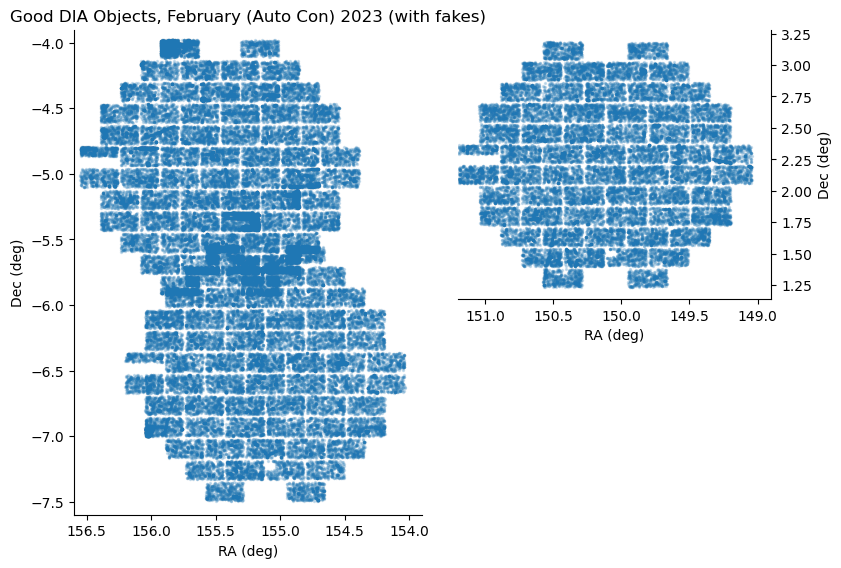

In [8]:
hitsPlot = plac.plotHitsSourcesOnSky(goodObj, title=f'Good DIA Objects, {month} {year} (with fakes)')

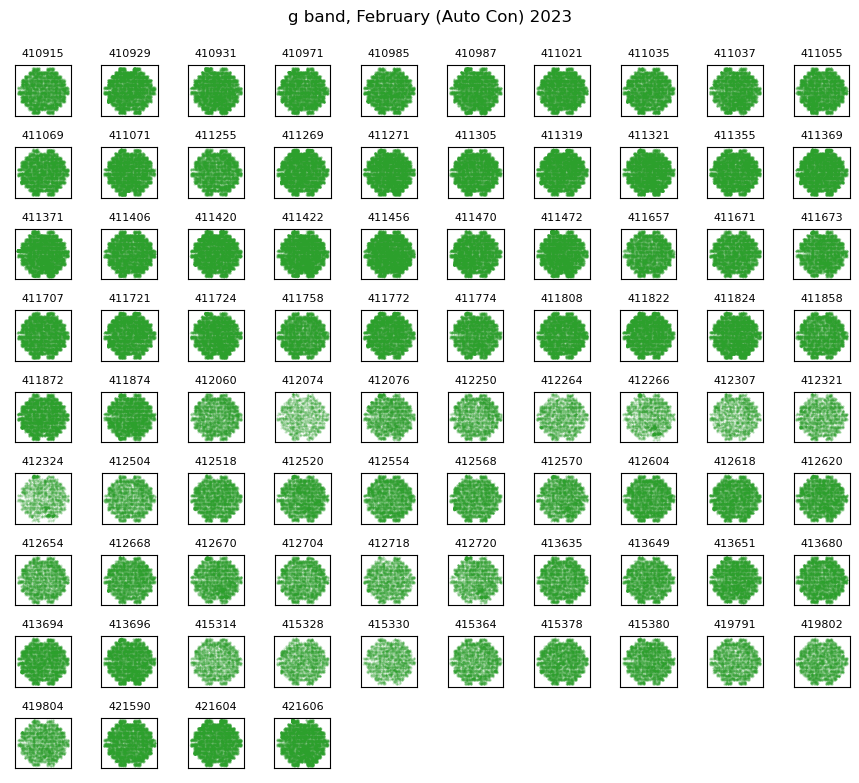

In [9]:
for band, color in zip(bandList, colorList):
    plac.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band], title=band+f' band, {month} {year}', color=color, size=1)

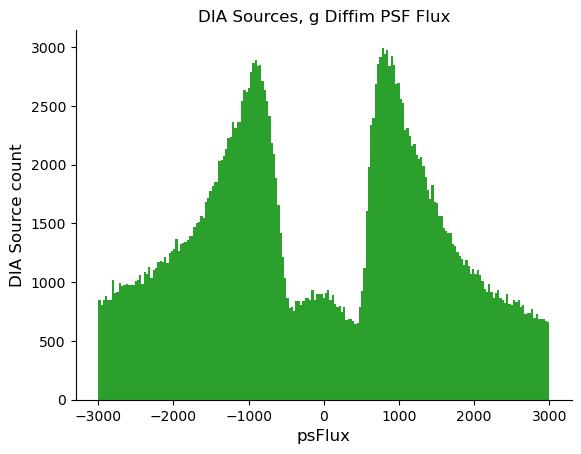

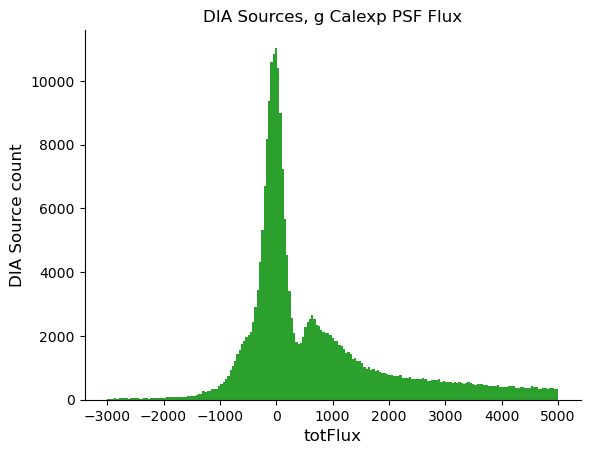

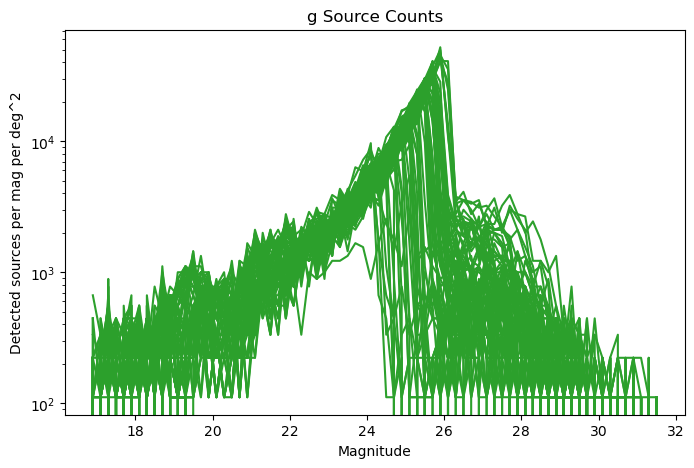

In [10]:
for band, color in zip(bandList, colorList):
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                        title=f'DIA Sources, {band} Diffim PSF Flux', color1=color, binmin=-3e3, binmax=3e3)
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                        title=f'DIA Sources, {band} Calexp PSF Flux', color1=color, binmin=-3e3, binmax=5e3)
    plac.source_magnitude_histogram(repo, goodSrc, band, 'DECam', collection)

## 3. <a id="section_3">Comparison to previous processing run</a>

Noticeable increase in DIA objects and sources. DIA sources increased sharply at about 1000 psflux. Flags are consistent.

Text(0.5, 1.0, 'Comparing DIA Object and Source counts (with fakes)')

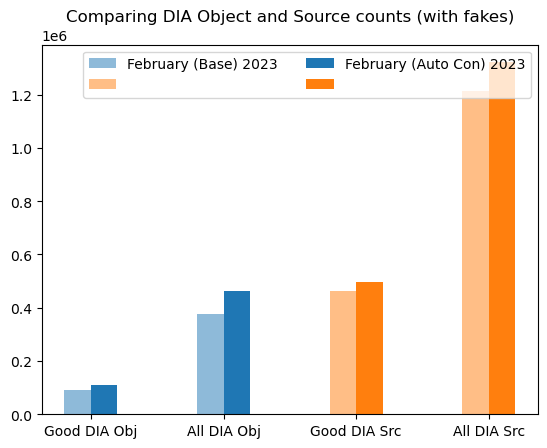

In [11]:
label1 = f'{month_old} {year_old}'
label2 = f'{month} {year}'

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.2

# Previous Run
ax.bar(xbar - width/2, [len(goodObj_old), len(objTable_old)], 
       width, label=label1, color='C0', alpha=0.5)
ax.bar(xbar + 2 - width/2, [len(goodSrc_old), len(srcTable_old)],
       width, label=' ', color='C1', alpha=0.5)

# Current Run
ax.bar(xbar + width/2, [len(goodObj), len(objTable)], 
       width, label=label2, color='C0')
ax.bar(xbar + 2 + width/2, [len(goodSrc), len(srcTable)],
       width, label=' ', color='C1')

plt.legend(ncol=2)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title('Comparing DIA Object and Source counts (with fakes)')

In [12]:
nObj = len(objTable)
nObj_old = len(objTable_old)

print(f"{month} {year}, Number of objects: ",nObj)
print(f"{month_old} {year_old}, Number of objects: ",nObj_old)

print("Diff: ", nObj-nObj_old)

February (Auto Con) 2023, Number of objects:  463407
February (Base) 2023, Number of objects:  375424
Diff:  87983


In [13]:
nGoodObj = len(goodObj)
nGoodObj_old = len(goodObj_old)

print(f"{month} {year}, Number of good objects: ",nGoodObj)
print(f"{month_old} {year_old}, Number of good objects: ",nGoodObj_old)

print("Diff: ", nGoodObj-nGoodObj_old)

February (Auto Con) 2023, Number of good objects:  110404
February (Base) 2023, Number of good objects:  93022
Diff:  17382


In [14]:
nSrc = len(srcTable)
nSrc_old = len(srcTable_old)

print(f"{month} {year}, Number of sources: ",nSrc)
print(f"{month_old} {year_old}, Number of sources: ",nSrc_old)

print("Diff: ", nSrc-nSrc_old)

February (Auto Con) 2023, Number of sources:  1321718
February (Base) 2023, Number of sources:  1212894
Diff:  108824


In [15]:
nGoodSrc = len(goodSrc)
nGoodSrc_old = len(goodSrc_old)

print(f"{month} {year}, Number of good sources: ",nGoodSrc)
print(f"{month_old} {year_old}, Number of good sources: ",nGoodSrc_old)

print("Diff: ", nGoodSrc-nGoodSrc_old)

February (Auto Con) 2023, Number of good sources:  495550
February (Base) 2023, Number of good sources:  461405
Diff:  34145


Text(0.5, 0.98, 'Good DIA Objects (with fakes)')

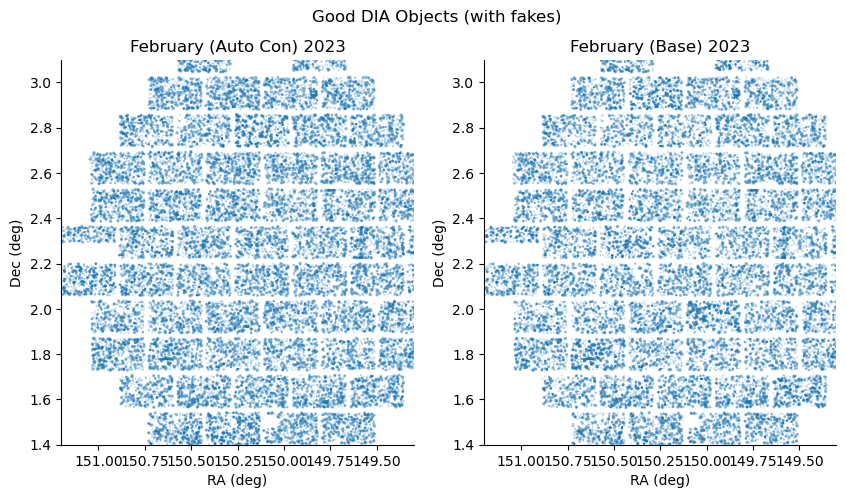

In [16]:
fig = plt.figure(figsize=(10,5))

cutoff = 0  # only plot DIA Objects composed of cutoff or more DIA Sources

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], 
           goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/3, 
           marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'{month} {year}')

ax2 = fig.add_subplot(122)
plt.setp(ax2, xlim=xlim, ylim=ylim)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'ra'], 
            goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'decl'], 
            c='C0', s=goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'nDiaSources']/3, 
            marker='.', alpha=0.4)
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.set_title(f'{month_old} {year_old}')

plt.suptitle('Good DIA Objects (with fakes)')

Text(0.5, 0.98, 'DIA Objects composed of > 3 "Good" DIA Sources (with fakes)')

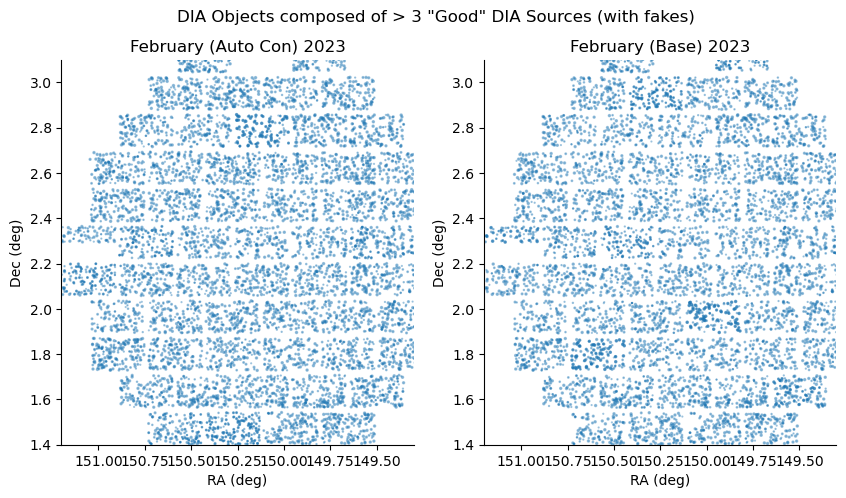

In [17]:
fig = plt.figure(figsize=(10,5))

cutoff = 3  # only plot DIA Objects composed of cutoff or more DIA Sources

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], 
           goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/3, 
           marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'{month} {year}')

ax2 = fig.add_subplot(122)
plt.setp(ax2, xlim=xlim, ylim=ylim)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'ra'], 
            goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'decl'], 
            c='C0', s=goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'nDiaSources']/3, 
            marker='.', alpha=0.4)
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.set_title(f'{month_old} {year_old}')

plt.suptitle(f'DIA Objects composed of > {cutoff} "Good" DIA Sources (with fakes)')

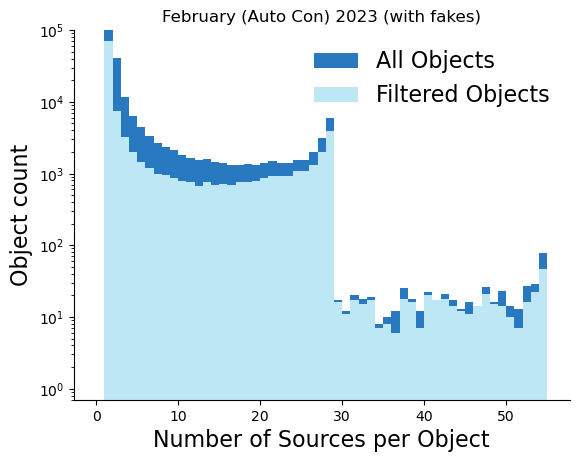

In [18]:
hist = plac.plotDiaObjectHistogram(objTable, goodObj, title=f'{month} {year} (with fakes)')

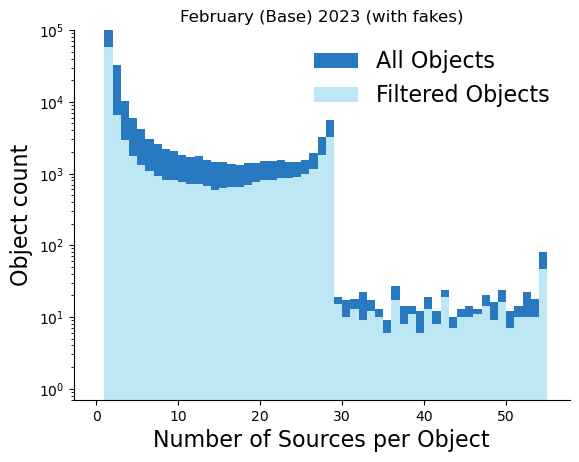

In [19]:
hist = plac.plotDiaObjectHistogram(objTable_old, goodObj_old, title=f'{month_old} {year_old} (with fakes)')

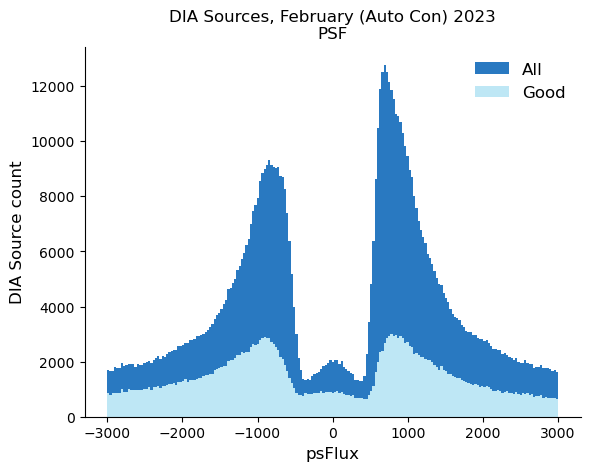

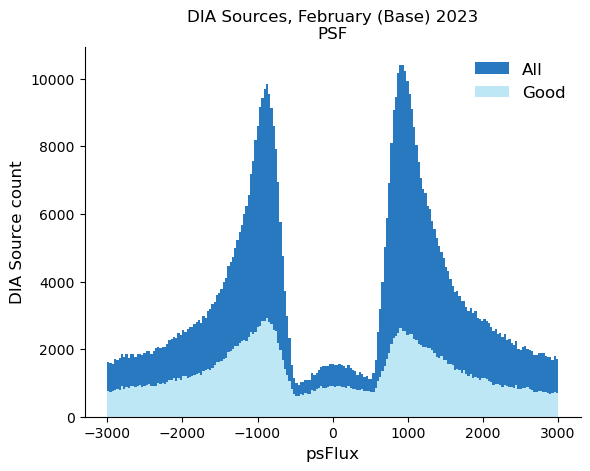

In [20]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}\nPSF')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}\nPSF')

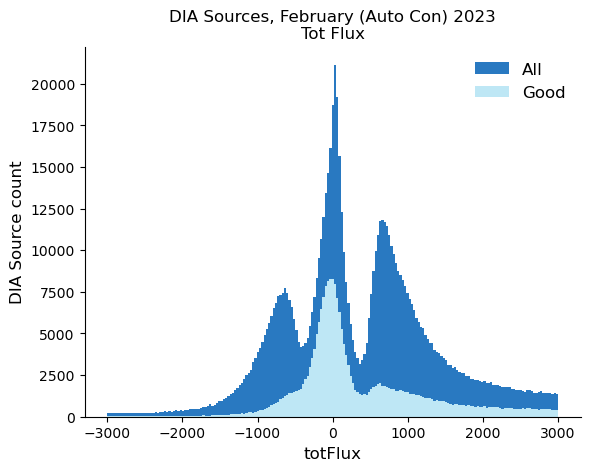

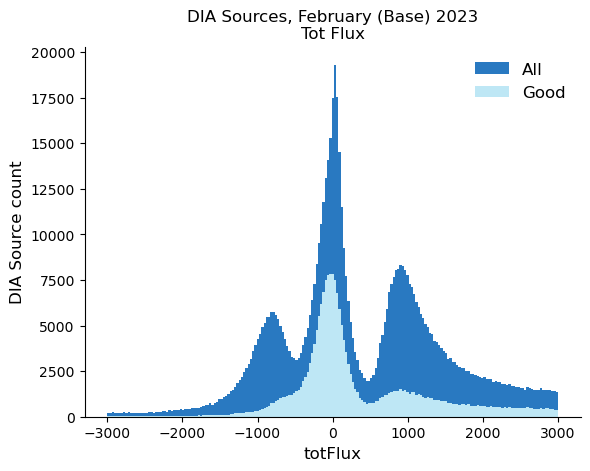

In [21]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}\nTot Flux')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}\nTot Flux')

In [22]:
def spatial_flag_plot(df, df2, flagName1, flagName2=None, operator=None, plotFlagged=True, 
                      plotUnFlagged=True, title='', title2=''):
    if flagName2 and operator:
        if operator == 'or':
            flagFilter = ((df[flagName1]) | (df[flagName2]))
            labelTrue = flagName1 + ' \nor ' + flagName2
            labelFalse = 'Neither ' + flagName1 + ' \nnor ' + flagName2
            
            flagFilter2 = ((df2[flagName1]) | (df2[flagName2]))
            labelTrue2 = flagName1 + ' \nor ' + flagName2
            labelFalse2 = 'Neither ' + flagName1 + ' \nnor ' + flagName2
        elif operator == 'and':
            flagFilter = ((df[flagName1]) & (df[flagName2]))
            labelTrue = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse = 'Not ' + flagName1 + ' \nand ' + flagName2
            
            flagFilter2 = ((df2[flagName1]) & (df2[flagName2]))
            labelTrue2 = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse2 = 'Not ' + flagName1 + ' \nand ' + flagName2
        else:
            raise ValueError('Operator must be \'and\' or \n \'or\'')
    elif flagName2 and not operator:
        raise ValueError('Operator must be set if a second flag is given')
    else:  # just considering one flag
        flagFilter = (df[flagName1])
        labelTrue = flagName1
        labelFalse = 'No ' + flagName1
        
        flagFilter2 = (df2[flagName1])
        labelTrue2 = flagName1
        labelFalse2 = 'No ' + flagName1
    flagFilterInverse = ~flagFilter
    flagFilterInverse2 = ~flagFilter2
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    if plotFlagged:
        scatterFlagged = ax.scatter(df.loc[flagFilter, 'ra'], df.loc[flagFilter, 'decl'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
        scatterFlagged = ax2.scatter(df2.loc[flagFilter2, 'ra'], df2.loc[flagFilter2, 'decl'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
    if plotUnFlagged:
        scatterUnflagged = ax.scatter(df.loc[flagFilterInverse, 'ra'], df.loc[flagFilterInverse, 'decl'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
        scatterUnflagged = ax2.scatter(df2.loc[flagFilterInverse2, 'ra'], df2.loc[flagFilterInverse2, 'decl'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
        
    print(f'--{month} {year}--')
    print('Flagged sources: {0}'.format(len(df.loc[flagFilter, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df.loc[flagFilterInverse, 'ra'])))
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title)
    
    print(f'--{month_old} {year_old}--')
    print('Flagged sources: {0}'.format(len(df2.loc[flagFilter2, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df2.loc[flagFilterInverse2, 'ra'])))
    ax2.set_xlabel('RA (deg)')
    ax2.set_ylabel('Dec (deg)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title(title2)
    
    xlim = (150.8, 149.8)
    ylim = (2.4, 3.1)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    plt.setp(ax2, xlim=xlim, ylim=ylim)
    plt.suptitle(f'Flagged vs Unflagged Sources (with fakes)')

--February (Auto Con) 2023--
Flagged sources: 689357
Unflagged sources: 632361
--February (Base) 2023--
Flagged sources: 591513
Unflagged sources: 621381


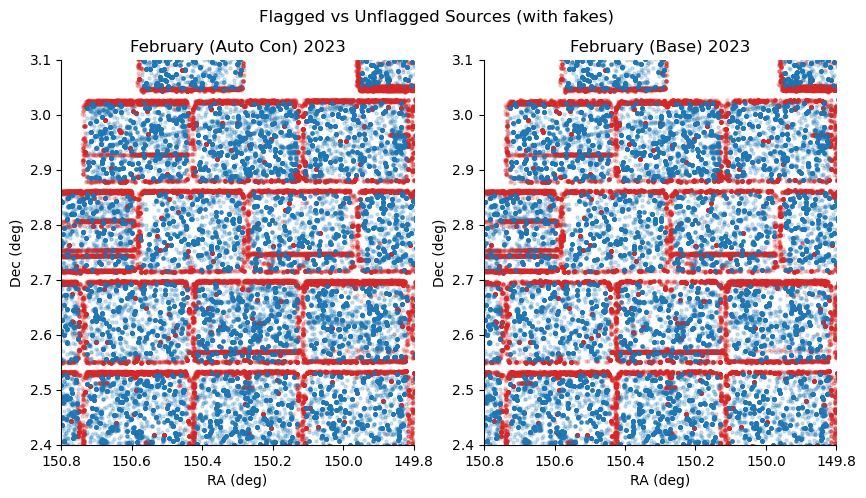

In [23]:
spatial_flag_plot(srcTableFlags, srcTableFlags_old, 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_suspect', operator='or',
                  title=f'{month} {year}', title2=f'{month_old} {year_old}')

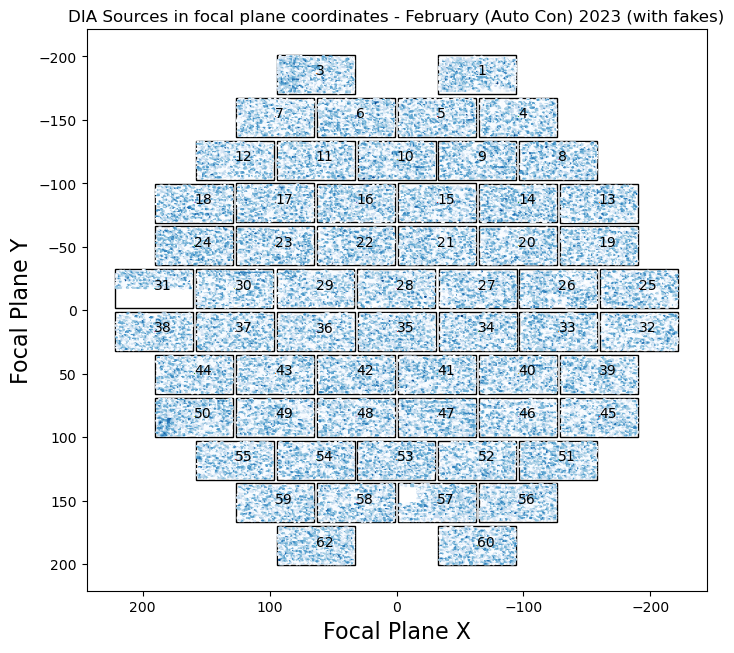

In [24]:
plac.plotDiaSourcesInFocalPlane(repo, goodSrc, title=f'- {month} {year} (with fakes)', instrument='DECam',
                               collections=collections)

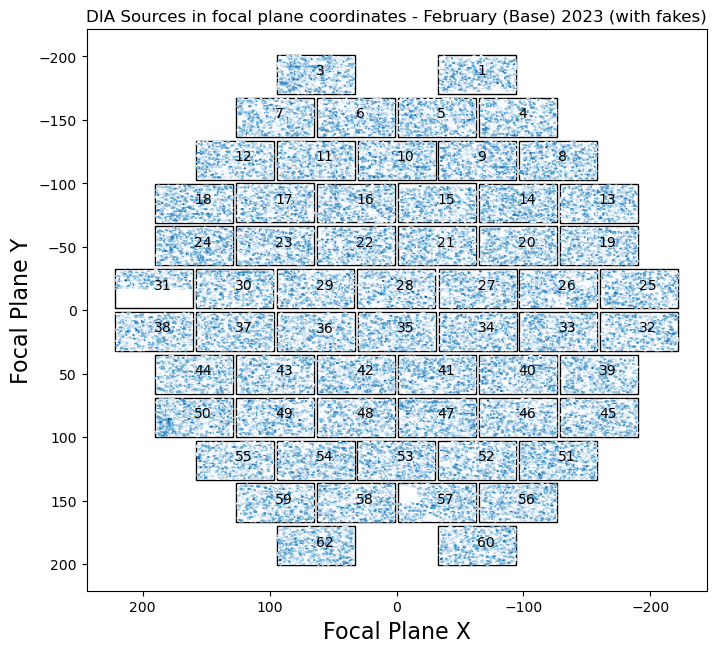

In [25]:
plac.plotDiaSourcesInFocalPlane(repo, goodSrc_old, title=f'- {month_old} {year_old} (with fakes)', instrument='DECam',
                               collections=collections_old)

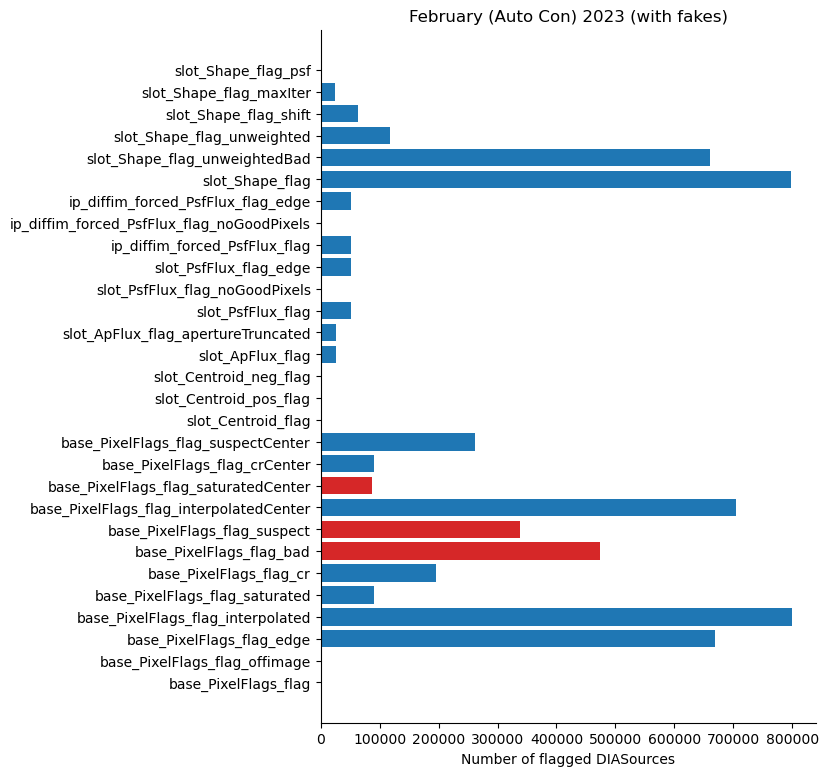

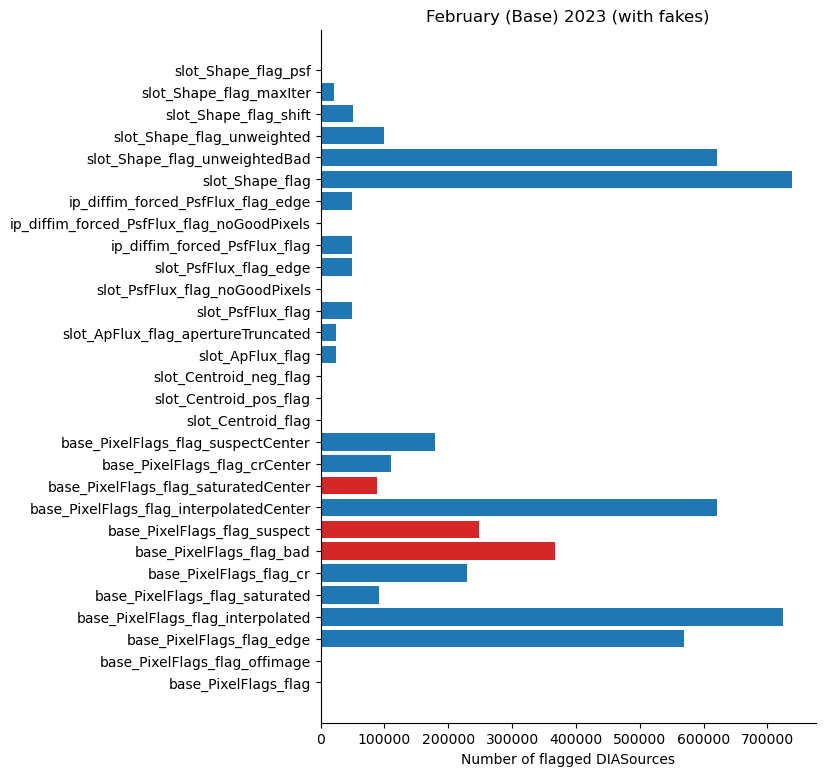

In [26]:
plac.plotFlagHist(srcTable, title=f'{month} {year} (with fakes)')
plac.plotFlagHist(srcTable_old, title=f'{month_old} {year_old} (with fakes)')

## 4. <a id="section_4">Separating the fake sources from the real sources</a>

In [27]:
tractList = [10054, 10055, 10056, 8122, 8123, 8362, 8363, 8364, 8604, 8605,
             8846, 8847, 9570, 9571, 9812, 9813, 9814]

In [28]:
dfs = [butler.get('fakes_fakeSourceCat', collections=collections,
                 instrument=instrument, skymap=skymap, tract=tract) for tract in tractList]
allInjectedFakes = pd.concat(dfs, ignore_index=True)

In [29]:
allInjectedFakes

fakeId       dec        ra  isVisitSource  \
0        9588247191044176697  0.055121  2.603926           True   
1       12688424431673891647  0.061915  2.616994           True   
2       13831324198459077941  0.080659  2.610914           True   
3       13434124367721235694  0.061271  2.594199           True   
4       13061384218026726521  0.074790  2.601716           True   
...                      ...       ...       ...            ...   
162872  12399018830711512619  0.027589  2.666088          False   
162873   9351365544218846664  0.042351  2.640017          False   
162874  12445833448818557558  0.043082  2.668239          False   
162875  12663927308451638731  0.055073  2.643180          False   
162876  13386882601012430122  0.028025  2.651862          False   

        isTemplateSource      u_mag      g_mag      r_mag      i_mag  \
0                  False  23.034274  23.034274  23.034274  23.034274   
1                  False  20.525169  20.525169  20.525169  20.525169   
2                  False  22.824213  22.824213  22.824213  22.824213   
3                  False  20.098034  20.098034  20.098034  20.098034   
4                  False  24.107792  24.107792  24.107792  24.107792   
...                  ...        ...        ...        ...        ...   
162872              True  20.928608  20.928608  20.928608  20.928608   
162873              True  22.447382  22.447382  22.447382  22.447382   
162874              True  23.763201  23.763201  23.763201  23.763201   
162875              True  21.571958  21.571958  21.571958  21.571958   
162876              True  21.979940  21.979940  21.979940  21.979940   

            z_mag      y_mag  disk_semimajor  bulge_semimajor  disk_n  \
0       23.034274  23.034274             1.0              1.0     1.0   
1       20.525169  20.525169             1.0              1.0     1.0   
2       22.824213  22.824213             1.0              1.0     1.0   
3       20.098034  20.098034             1.0              1.0     1.0   
4       24.107792  24.107792             1.0              1.0     1.0   
...           ...        ...             ...              ...     ...   
162872  20.928608  20.928608             1.0              1.0     1.0   
162873  22.447382  22.447382             1.0              1.0     1.0   
162874  23.763201  23.763201             1.0              1.0     1.0   
162875  21.571958  21.571958             1.0              1.0     1.0   
162876  21.979940  21.979940             1.0              1.0     1.0   

        bulge_n  disk_axis_ratio  bulge_axis_ratio  disk_pa  bulge_pa  \
0           1.0              1.0               1.0      0.0       1.0   
1           1.0              1.0               1.0      0.0       1.0   
2           1.0              1.0               1.0      0.0       1.0   
3           1.0              1.0               1.0      0.0       1.0   
4           1.0              1.0               1.0      0.0       1.0   
...         ...              ...               ...      ...       ...   
162872      1.0              1.0               1.0      0.0       1.0   
162873      1.0              1.0               1.0      0.0       1.0   
162874      1.0              1.0               1.0      0.0       1.0   
162875      1.0              1.0               1.0      0.0       1.0   
162876      1.0              1.0               1.0      0.0       1.0   

       sourceType  
0            star  
1            star  
2            star  
3            star  
4            star  
...           ...  
162872       star  
162873       star  
162874       star  
162875       star  
162876       star  

[162877 rows x 20 columns]

In [30]:
dfs_old = [butler.get('fakes_fakeSourceCat', collections=collections_old,
                 instrument=instrument, skymap=skymap, tract=tract) for tract in tractList]
allInjectedFakes_old = pd.concat(dfs, ignore_index=True)

In [31]:
def collectMatchedDiaSources(fakesMatchDiaSrc, maxi=-1):
    """Given a butler query of fakesMatchDiaSrc datasetRefs, create a pandas dataframe with them all.
    'All' is defined as up to maxi of them, so it doesn't take forever.
    
    If you really want all of them, set maxi to -1.
    """
    #%%time
    visitDetectorFrames = []

    i = 0

    for datasetRef in fakesMatchDiaSrc: 
        try:
            frame = butler.getDirect(datasetRef)
            # nondetected sources don't have DIASource records--so propagate metadata to all rows
            # grab a detected row
            w = frame['diaSourceId'] > 0
            if np.sum(w) == 0:
                print(f'No real sources detected in {datasetRef}')
                continue
            ccdVisitId = int(frame.loc[w,'ccdVisitId'].iloc[0])
            filterName = frame.loc[w,'filterName'].iloc[0]
            # propagate to all rows
            frame.loc[:,'ccdVisitId'] = ccdVisitId 
            frame.loc[:,'filterName'] = filterName 
        except Exception as e:
            raise(e)
        else:
            visitDetectorFrames.append(frame)
        i+=1
        if i == maxi:
            break

    matchedDiaSources = pd.concat(visitDetectorFrames)
    
    matchedDiaSources.loc[:,'ra'] = np.degrees(matchedDiaSources['ra_x'])
    matchedDiaSources.loc[:,'decl'] = np.degrees(matchedDiaSources['dec'])

    return matchedDiaSources

In [32]:
fakesMatchDiaSrc = butler.registry.queryDatasets(collections=collections,
                                                 datasetType='fakes_goodSeeingDiff_matchDiaSrc')
matchedDiaSources = collectMatchedDiaSources(fakesMatchDiaSrc)

In [33]:
fakesMatchDiaSrc_old = butler.registry.queryDatasets(collections=collections_old,
                                                 datasetType='fakes_goodSeeingDiff_matchDiaSrc')
matchedDiaSources_old = collectMatchedDiaSources(fakesMatchDiaSrc_old)

In [34]:
instrumentDataId = butler.registry.expandDataId(instrument=instrument)
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
dataId = packer.unpack(matchedDiaSources.ccdVisitId)
matchedDiaSources['visit'] = dataId['visit']
matchedDiaSources['detector'] = dataId['detector']

In [35]:
dataId_old = packer.unpack(matchedDiaSources_old.ccdVisitId)
matchedDiaSources_old['visit'] = dataId_old['visit']
matchedDiaSources_old['detector'] = dataId_old['detector']

In [36]:
matchedDiaSources

fakeId       dec      ra_x  isVisitSource  \
0    11646449845644558216 -0.080987  2.717492           True   
1    11658202745225495573 -0.081369  2.717497           True   
2    12807158085566493290 -0.081798  2.718181           True   
3    12080769583442123778 -0.082274  2.716816           True   
4    12689309878938875945 -0.081122  2.717711           True   
..                    ...       ...       ...            ...   
101  10106884137687035049  0.032154  2.636005          False   
102   9563929670822716018  0.031133  2.635640          False   
103  12838741571664931952  0.030393  2.636201          False   
104  11371263900703981154  0.032085  2.635734          False   
105  10332095219998309498  0.032186  2.635594          False   

     isTemplateSource      u_mag      g_mag      r_mag      i_mag      z_mag  \
0               False  23.695598  23.795088  23.695598  23.695598  23.695598   
1               False  20.389130  20.700833  20.389130  20.389130  20.389130   
2               False  21.394992  20.928142  21.394992  21.394992  21.394992   
3               False  22.200085  22.820156  22.200085  22.200085  22.200085   
4               False  22.170022  21.990383  22.170022  22.170022  22.170022   
..                ...        ...        ...        ...        ...        ...   
101              True  20.073744 -20.073744  20.073744  20.073744  20.073744   
102              True  23.575268 -23.575268  23.575268  23.575268  23.575268   
103              True  21.352864 -21.352864  21.352864  21.352864  21.352864   
104              True  21.157954 -21.157954  21.157954  21.157954  21.157954   
105              True  20.122103 -20.122103  20.122103  20.122103  20.122103   

     ...  totFluxErr       ixx       iyy       ixy    ixxPSF    iyyPSF  \
0    ...  100.792104  0.110933  0.077933  0.001352  0.130065 -0.001343   
1    ...   97.993787  0.136902  0.127377 -0.002963  0.130117 -0.001344   
2    ...   98.173519  0.145402  0.137032 -0.009322  0.130120 -0.001344   
3    ...   97.850169  0.192653  0.163774  0.003017  0.130222 -0.001345   
4    ...   98.629942  0.125011  0.118128 -0.003204  0.130070 -0.001343   
..   ...         ...       ...       ...       ...       ...       ...   
101  ...  144.383000       NaN       NaN       NaN  0.183913  0.010942   
102  ...         NaN       NaN       NaN       NaN       NaN       NaN   
103  ...  145.150647       NaN       NaN       NaN  0.184055  0.010951   
104  ...  143.296269       NaN       NaN       NaN  0.183896  0.010941   
105  ...  144.074546       NaN       NaN       NaN  0.183874  0.010940   

       ixyPSF          ra   visit detector  
0   -0.001343  155.700851  411371       22  
1   -0.001344  155.701113  411371       22  
2   -0.001344  155.740281  411371       22  
3   -0.001345  155.662075  411371       22  
4   -0.001343  155.713378  411371       22  
..        ...         ...     ...      ...  
101  0.010942  151.031975  410971       50  
102       NaN  151.011066  410971       50  
103  0.010951  151.043177  410971       50  
104  0.010941  151.016456  410971       50  
105  0.010940  151.008437  410971       50  

[451872 rows x 68 columns]

Text(0.5, 1.0, 'DIA Objects, Fakes, and Matched DIA Sources, February (Auto Con) 2023')

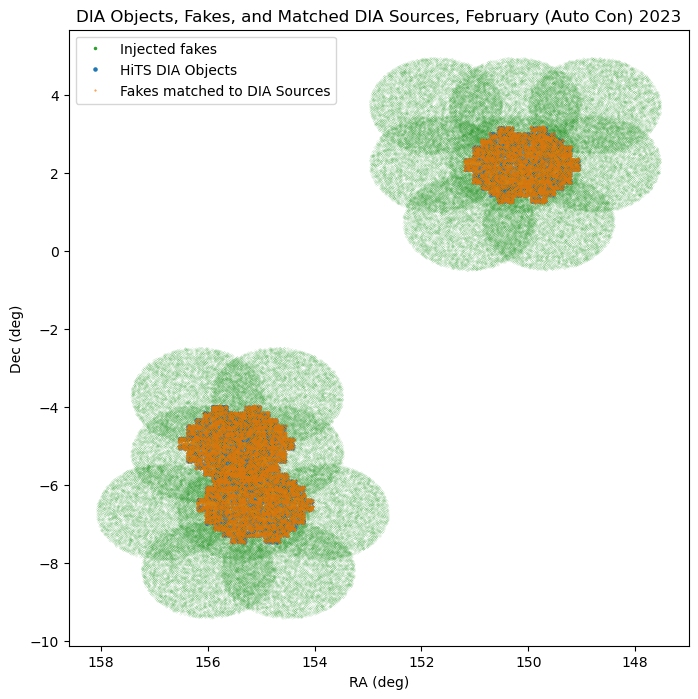

In [37]:
plt.figure(figsize=(8,8))
plt.plot(allInjectedFakes.ra*u.rad.to(u.deg), allInjectedFakes.dec*u.rad.to(u.deg),
         ls='None', marker='.', ms=0.1, label="Injected fakes", color='C2')
plt.plot(goodObj.ra, goodObj.decl, ls='None', marker='.', ms=0.15, label="HiTS DIA Objects", color='C0')
plt.plot(matchedDiaSources.ra_x*u.rad.to(u.deg), matchedDiaSources.dec*u.rad.to(u.deg), ls='None', marker='.',
         ms=0.03, label="Fakes matched to DIA Sources", color='C1')
plt.gca().invert_xaxis()
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.legend(markerscale=30)
plt.title(f'DIA Objects, Fakes, and Matched DIA Sources, {month} {year}')

In [38]:
nFakesMatched = len(matchedDiaSources)
nFakesMatched_old = len(matchedDiaSources_old)

print(f"{month} {year}, Number of matched fake sources:", nFakesMatched)
print(f"{month_old} {year_old}, Number of matched fake sources:", nFakesMatched_old)

print("Diff: ", nFakesMatched-nFakesMatched_old)

February (Auto Con) 2023, Number of matched fake sources: 451872
February (Base) 2023, Number of matched fake sources: 451872
Diff:  0


In [39]:
nFakesDiff = len(srcTable) - nFakesMatched
nFakesDiff_old = len(srcTable_old) - nFakesMatched_old

print(f"{month} {year}, Number of non-fake DIA Sources: ", nFakesDiff)
print(f"{month_old} {year_old}, Number of non-fake DIA Sources: ", nFakesDiff_old)

print("Diff: ", nFakesDiff-nFakesDiff_old)

February (Auto Con) 2023, Number of non-fake DIA Sources:  869846
February (Base) 2023, Number of non-fake DIA Sources:  761022
Diff:  108824


visit 410915: 14469 DIA Sources, 5393 matched injected fakes
visit 410929: 20432 DIA Sources, 5362 matched injected fakes
visit 410931: 21986 DIA Sources, 5370 matched injected fakes
visit 410971: 19598 DIA Sources, 5397 matched injected fakes
visit 410985: 17721 DIA Sources, 5371 matched injected fakes
visit 410987: 22091 DIA Sources, 5371 matched injected fakes
visit 411021: 17421 DIA Sources, 5386 matched injected fakes
visit 411035: 16359 DIA Sources, 5376 matched injected fakes
visit 411037: 17684 DIA Sources, 5380 matched injected fakes
visit 411055: 16407 DIA Sources, 5401 matched injected fakes
visit 411069: 17818 DIA Sources, 5382 matched injected fakes
visit 411071: 22248 DIA Sources, 5374 matched injected fakes
visit 411255: 14247 DIA Sources, 5385 matched injected fakes
visit 411269: 21574 DIA Sources, 5377 matched injected fakes
visit 411271: 24899 DIA Sources, 5371 matched injected fakes
visit 411305: 19525 DIA Sources, 5391 matched injected fakes
visit 411319: 22813 DIA 

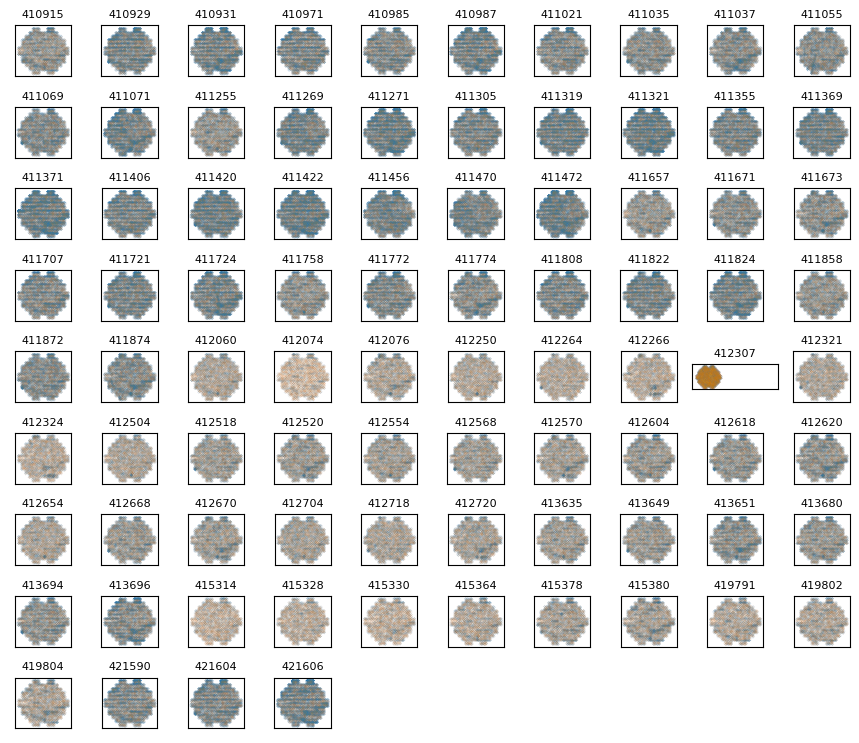

In [40]:
# Plot visit-by-visit: DIA Sources (blue) and inserted fakes (orange)

sourceTablePlot = srcTable

visits = np.unique(sourceTablePlot['visit'])
nVisits = len(visits)
if np.floor(np.sqrt(nVisits)) - np.sqrt(nVisits) == 0:
    squareGridSize = int(np.sqrt(nVisits))
else:
    squareGridSize = int(np.sqrt(nVisits)) + 1

fig = plt.figure(figsize=(9, 9))
for count, visit in enumerate(np.unique(sourceTablePlot['visit'].values)):
    idx = sourceTablePlot.visit == visit
    ax = fig.add_subplot(squareGridSize, squareGridSize, count + 1, aspect='equal')
    ax.scatter(sourceTablePlot.ra[idx], sourceTablePlot.decl[idx], c='C0', marker='.', s=0.01, alpha=0.3)
    
    fakeSources = matchedDiaSources.loc[matchedDiaSources.visit == visit]
    ax.scatter(fakeSources.ra_x*u.rad.to(u.deg), fakeSources.dec*u.rad.to(u.deg),
               c='C1', marker='.', s=0.01, alpha=0.3)
    
    ax.set_title(visit, size=8)
    ax.invert_xaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(f'visit {visit}: {len(sourceTablePlot.loc[sourceTablePlot.visit == visit])} DIA Sources, {len(fakeSources)} matched injected fakes')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0)

Text(0.5, 1.0, 'Stacked Visits, February (Auto Con) 2023')

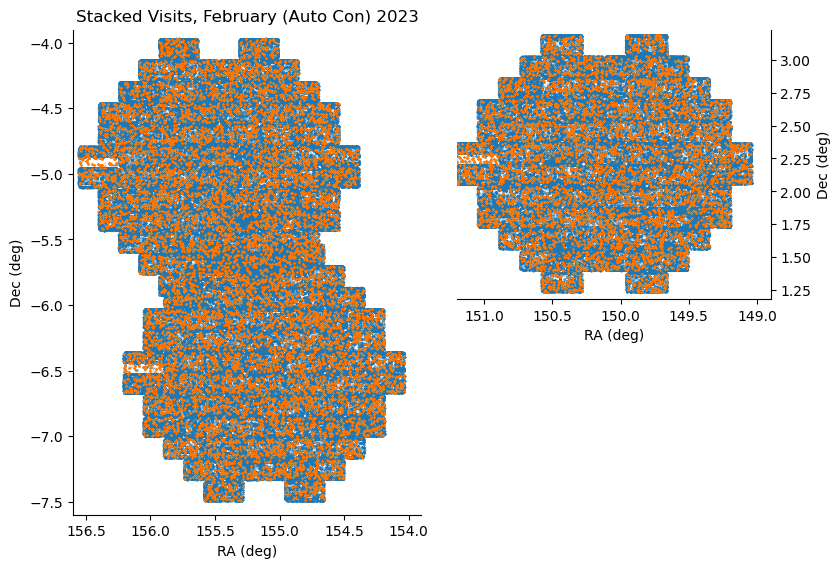

In [41]:
# Same as above but all on top of each other instead of broken out by visit
plt.figure(figsize=(9, 7))
ax1 = plt.subplot2grid((100, 100), (0, 55),
                       rowspan=50, colspan=45)  # 1 single HiTS field, on the right
ax2 = plt.subplot2grid((100, 100), (0, 0),
                       rowspan=90, colspan=50)  # 2 overlapping HiTS fields, on the left

ax1Filter = (srcTable['decl'] > -2)
ax2Filter = (~ax1Filter)

ax1.scatter(srcTable.loc[ax1Filter, 'ra'],
            srcTable.loc[ax1Filter, 'decl'],
            c='C0', s=0.1, alpha=0.5)
ax1.scatter(matchedDiaSources.ra_x*u.rad.to(u.deg), matchedDiaSources.dec*u.rad.to(u.deg), c='C1', s=0.05, alpha=0.5)
ax2.scatter(srcTable.loc[ax2Filter, 'ra'],
            srcTable.loc[ax2Filter, 'decl'],
            c='C0', s=0.1, alpha=0.5)
ax2.scatter(matchedDiaSources.ra_x*u.rad.to(u.deg), matchedDiaSources.dec*u.rad.to(u.deg), c='C1', s=0.05, alpha=0.5)

ax1.set_xlabel('RA (deg)')
ax2.set_xlabel('RA (deg)')
ax1.set_ylabel('Dec (deg)')
ax2.set_ylabel('Dec (deg)')

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax1.set_xlim(151.2, 148.9)
ax1.set_ylim(1.18, 3.23)
ax2.set_xlim(156.6, 153.9)
ax2.set_ylim(-7.6, -3.9)

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

#plt.title(title)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.title(f'Stacked Visits, {month} {year}')

## 5. <a id="section_5">Fakes completeness analysis</a>

In [42]:
def completenessByBandPlot(matchedDiaSources, bandList, colorList, figsize, flux_col_suffix='_mag', show_spatial=True):
    
    plt.figure(figsize=figsize)

    # Some filters
    wScienceOnly = matchedDiaSources['isVisitSource'] & ~matchedDiaSources['isTemplateSource']
    wMatched = matchedDiaSources['diaSourceId'] > 0
    
    plt.title('Spatial distribution of matched DIA Sources')
    
    plt.scatter(matchedDiaSources.loc[wScienceOnly & wMatched,'ra'], \
                matchedDiaSources.loc[wScienceOnly & wMatched,'decl'],
                marker='x', s=3, label='Matched science fake')
    plt.scatter(matchedDiaSources.loc[wScienceOnly & ~wMatched,'ra'], \
                matchedDiaSources.loc[wScienceOnly & ~wMatched,'decl'],
                marker='.', s=3, label='Unmatched science fake')
    
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')
    plt.legend()

    if show_spatial:
        for band in bandList:
            completeness_byband = {}
            completeness_err_byband = {}
            bins = np.linspace(20, 26, 70)

            wband = matchedDiaSources['filterName'] == band
            matched_filter = (wMatched & wScienceOnly &  wband)
            unmatched_filter = (~wMatched & wScienceOnly & wband)

            n_matched, edges = np.histogram(matchedDiaSources.loc[matched_filter, f'{band}{flux_col_suffix}'], bins=bins)
            n_unmatched, edges = np.histogram(matchedDiaSources.loc[unmatched_filter, f'{band}{flux_col_suffix}'], bins=bins)

            ntot = n_matched + n_unmatched
            nmatched_err = np.sqrt(n_matched)
            completeness_byband[band] = n_matched/ntot

            # Attempt to compute some kind of error
            ntot_err = np.sqrt(ntot) # compute on total to keep Poisson errors in gaussian regime
            completeness_err_byband[band] = completeness_byband[band] * \
                                            np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)

        plt.figure(figsize=(8, 6))
        for band, color in zip(bandList, colorList):
            plt.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color, label=band)
        plt.axhline(.9, ls='--', color='0.75')#, label='90%')
        plt.legend(loc='lower left')
        plt.xlabel('Injected magnitude')
        plt.ylabel('Fractional completeness')
        plt.title('Completeness for sources injected into science (visit) images')

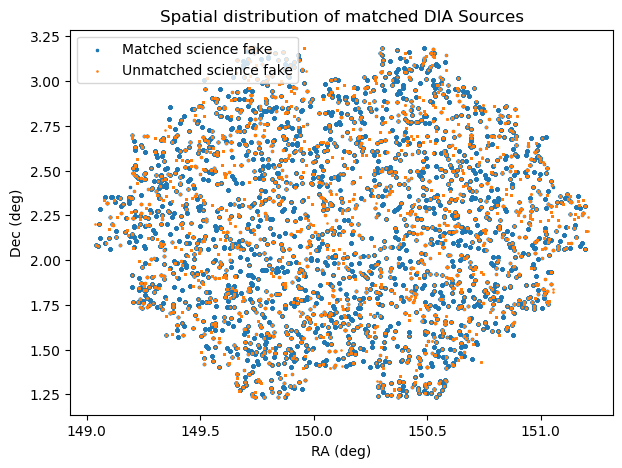

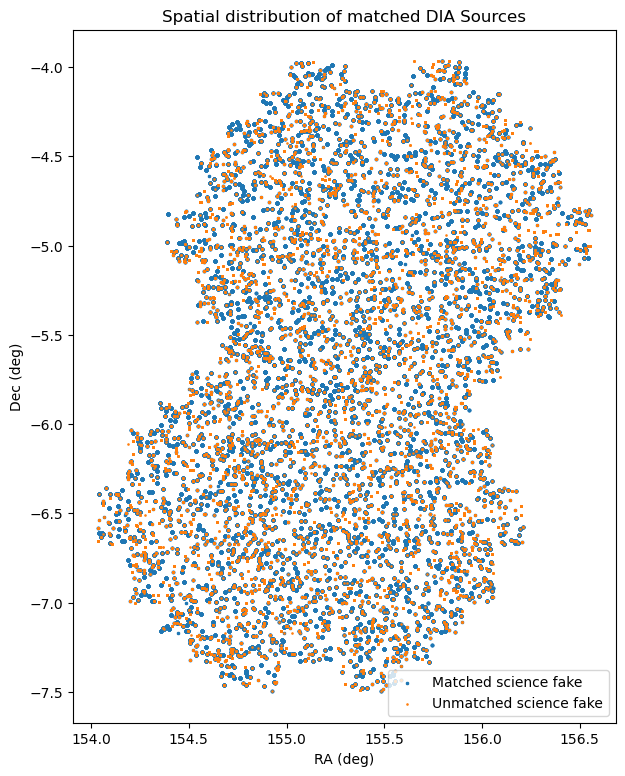

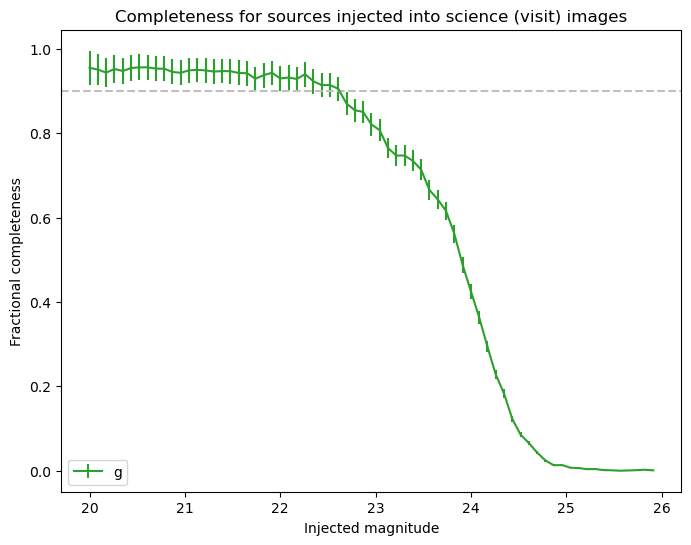

In [43]:
bandList = ['g']
colorList = ['C2']

ax1Filter = (matchedDiaSources['decl'] > -2)
ax2Filter = (~ax1Filter)

completenessByBandPlot(matchedDiaSources.loc[ax1Filter], bandList, colorList, (7, 5), flux_col_suffix='_mag', show_spatial=False)
completenessByBandPlot(matchedDiaSources.loc[ax2Filter], bandList, colorList, (7, 9), flux_col_suffix='_mag', show_spatial=True)

## 6. <a id="section_6">SNR distributions</a>
Compared to October notebook. The SNR distribution does not go higher than 8000, previous run had an additional bin higher than 10000. No change in the approximate SNR distribution for difference image fluxes. The negative approximate SNR distribution for forced source photometry fluxes has fewer has roughly the same amount of negative bins, but they are closer to zero.

Text(0.5, 0, 'SNR of DIA Sources')

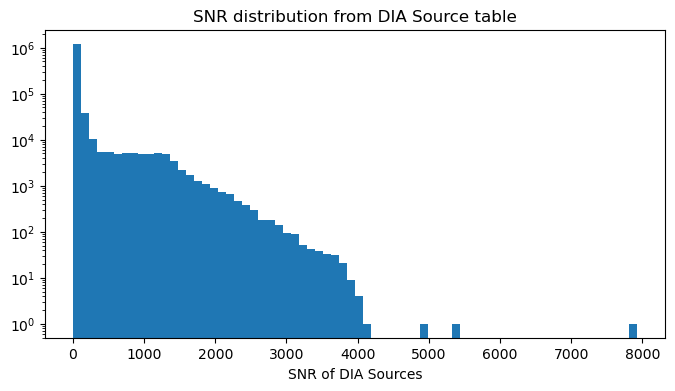

In [44]:
plt.figure(figsize=(8,4))
plt.yscale('log')
snrHist = plt.hist(srcTable.snr, bins=70)
plt.title('SNR distribution from DIA Source table')
plt.xlabel('SNR of DIA Sources')

In [45]:
# Pre-snr column:
srcTable['psFluxSNR'] = srcTable.psFlux / srcTable.psFluxErr
srcTable['totFluxSNR'] = srcTable.totFlux / srcTable.totFluxErr

Text(0.5, 0, 'psFlux/psFluxErr')

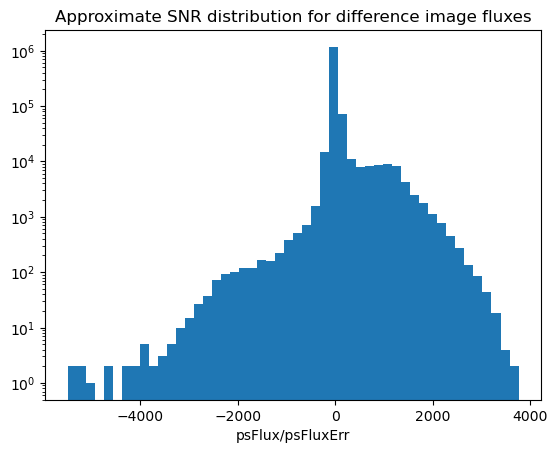

In [46]:
plt.figure()
plt.yscale('log')
psFluxHist = plt.hist(srcTable.psFluxSNR, bins=50)
plt.title('Approximate SNR distribution for difference image fluxes')
plt.xlabel('psFlux/psFluxErr')

Text(0.5, 0, 'totFlux/totFluxErr')

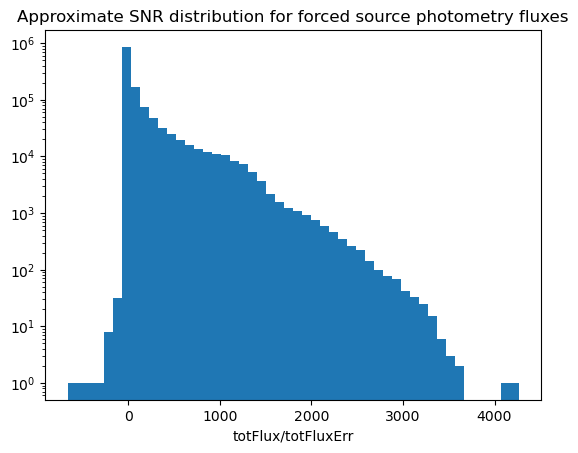

In [47]:
plt.figure()
plt.yscale('log')
totFluxHist = plt.hist(srcTable.totFluxSNR, bins=50)
plt.title('Approximate SNR distribution for forced source photometry fluxes')
plt.xlabel('totFlux/totFluxErr')